<a href="https://colab.research.google.com/github/adas-quant/mscfe-gwp1-yieldcurve/blob/arindam-task2/notebooks/02_Task2_YieldCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 — Yield Curve Modeling

## Objective
- Pick government securities from one country(India)
- Fit Nelson-Siegel model.
- Fit Cubic-Spline model.
- Compare models in terms of fit & interpretation.
- Discuss smoothing vs. ethics.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error


In [13]:


# Example: scrape CCIL tenor-wise yields (they might publish via HTML table)
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)   # this yields a list of DataFrames
for i, tab in enumerate(tables):
    print("Table", i)
    print(tab.head())


Table 0
                    Date Tenor Bucket              Security  YTM (%)
0  2025-10-03 00:00:00.0          91D   91 DTB (02/01/2026)   5.4881
1  2025-10-03 00:00:00.0         182D  182 DTB (03/04/2026)   5.5899
2  2025-10-03 00:00:00.0         364D  364 DTB (02/10/2026)   5.5999
3  2025-10-03 00:00:00.0        1Y-2Y         7.38% GS 2027   5.6511
4  2025-10-03 00:00:00.0        4Y-5Y         6.01% GS 2030   6.1066


In [14]:

# CCIL tenor-wise yields URL
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"

# Read all HTML tables
tables = pd.read_html(url)

# Pick the first table (the one with yields)
table = tables[0]

# Display full table without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print(table)


                     Date Tenor Bucket                Security  YTM (%)
0   2025-10-03 00:00:00.0          91D     91 DTB (02/01/2026)   5.4881
1   2025-10-03 00:00:00.0         182D    182 DTB (03/04/2026)   5.5899
2   2025-10-03 00:00:00.0         364D    364 DTB (02/10/2026)   5.5999
3   2025-10-03 00:00:00.0        1Y-2Y           7.38% GS 2027   5.6511
4   2025-10-03 00:00:00.0        4Y-5Y           6.01% GS 2030   6.1066
5   2025-10-03 00:00:00.0       9Y-10Y           6.33% GS 2035   6.5104
6   2025-10-03 00:00:00.0      13Y-15Y           6.68% GS 2040   6.8047
7   2025-10-03 00:00:00.0      28Y-30Y           7.24% GS 2055   7.1218
8   2025-10-03 00:00:00.0           5Y  7.30% UTTARAKHAND 2032   7.3000
9   2025-10-03 00:00:00.0          10Y          7.37% GOA 2036   7.3700
10  2025-10-03 00:00:00.0          15Y       7.49% KERALA 2040   7.4900


In [15]:

# Load CCIL table
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
df = tables[0]

# Display raw table
df.head(15)


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218
8,2025-10-03 00:00:00.0,5Y,7.30% UTTARAKHAND 2032,7.3000
9,2025-10-03 00:00:00.0,10Y,7.37% GOA 2036,7.3700


In [16]:
# Keep rows where 'Security' contains 'GS' or 'DTB' (T-Bills)
df_gs = df[df['Security'].str.contains("GS|DTB", case=False, na=False)].copy()

df_gs


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218


In [17]:
# Mapping tenor buckets to approx years
tenor_map = {
    "182D": 0.5,
    "364D": 1,
    "1Y-2Y": 1,
    "9Y-10Y": 10,
    "10Y": 10,
    "13Y-15Y": 15,
    "15Y": 15,
    "28Y-30Y": 30,
    "30Y": 30,
    "40Y": 40
}

# Add "Years" column
df_gs["Years"] = df_gs["Tenor Bucket"].map(tenor_map)

# Drop rows where we don’t have mapping
df_curve = df_gs.dropna(subset=["Years"]).copy()

df_curve


,Date,Tenor Bucket,Security,YTM (%),Years
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899,0.5
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999,1.0
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511,1.0
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104,10.0
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047,15.0
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218,30.0


In [18]:
yield_curve = df_curve[["Date", "Years", "YTM (%)"]].sort_values("Years")

yield_curve


,Date,Years,YTM (%)
1,2025-10-03 00:00:00.0,0.5,5.5899
2,2025-10-03 00:00:00.0,1.0,5.5999
3,2025-10-03 00:00:00.0,1.0,5.6511
5,2025-10-03 00:00:00.0,10.0,6.5104
6,2025-10-03 00:00:00.0,15.0,6.8047
7,2025-10-03 00:00:00.0,30.0,7.1218


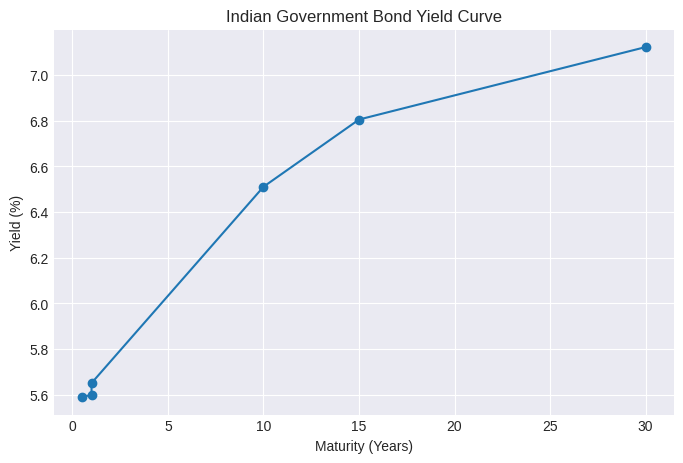

In [19]:

plt.figure(figsize=(8,5))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], marker="o")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve")
plt.grid(True)
plt.show()


## Maturities ranging from short-term to long-term (e.g. 6 month maturity to 20 or 30 year maturities

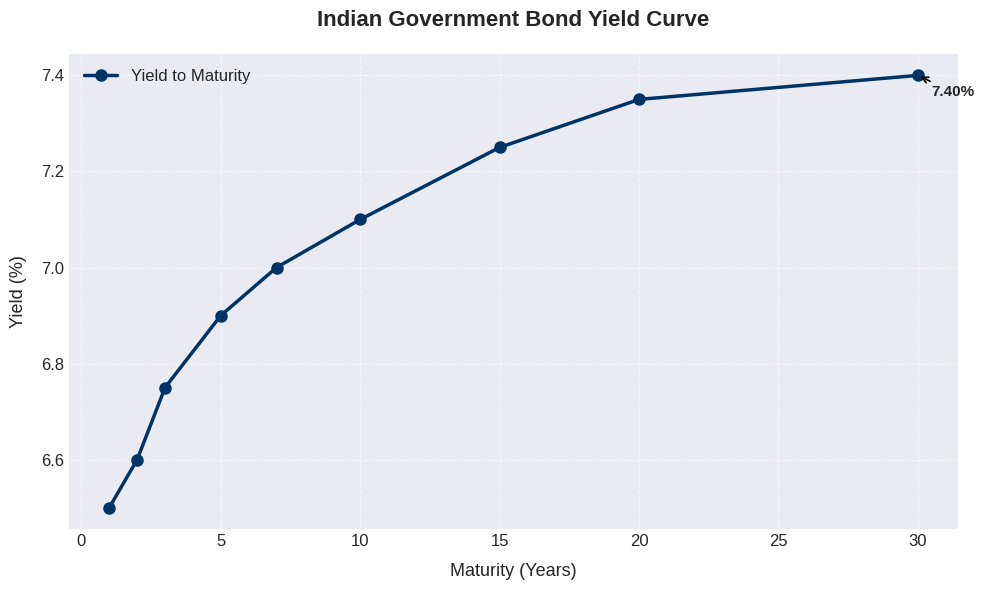

In [20]:
# Indian Government Bonds
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10,6))

# Plot
ax.plot(
    yield_curve["Years"],
    yield_curve["YTM (%)"],
    marker="o",
    markersize=8,
    linewidth=2.5,
    color="#003366",
    label="Yield to Maturity"
)

# Titles and labels
ax.set_title("Indian Government Bond Yield Curve", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Maturity (Years)", fontsize=13, labelpad=10)
ax.set_ylabel("Yield (%)", fontsize=13, labelpad=10)

ax.tick_params(axis="both", which="major", labelsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(True, linestyle="--", alpha=0.6)

max_point = yield_curve.iloc[-1]
ax.annotate(
    f"{max_point['YTM (%)']:.2f}%",
    (max_point["Years"], max_point["YTM (%)"]),
    xytext=(10, -15),
    textcoords="offset points",
    fontsize=11,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.2)
)

ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


## Fit a Nelson-Siegel model

Fitted Parameters:
β0 (Level):   7.5605
β1 (Slope):   -1.2006
β2 (Curv.):   0.0007
λ (Decay):    0.2564


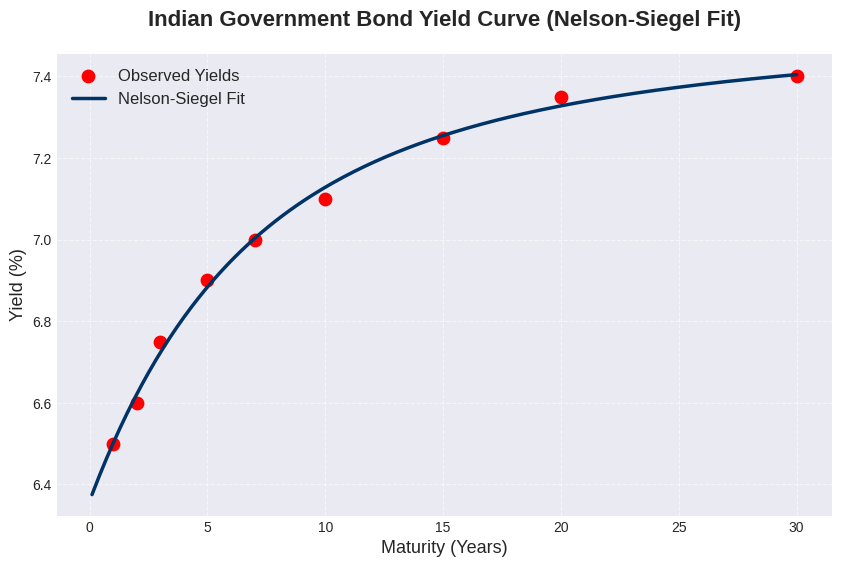

In [23]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit curve
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)

beta0, beta1, beta2, lambd = popt
print("Fitted Parameters:")
print(f"β0 (Level):   {beta0:.4f}")
print(f"β1 (Slope):   {beta1:.4f}")
print(f"β2 (Curv.):   {beta2:.4f}")
print(f"λ (Decay):    {lambd:.4f}")

# Smooth curve for plotting
tau_range = np.linspace(0.1, 30, 200)
fitted_curve = nelson_siegel(tau_range, *popt)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="red", s=80, label="Observed Yields")
plt.plot(tau_range, fitted_curve, color="#003366", linewidth=2.5, label="Nelson-Siegel Fit")
plt.title("Indian Government Bond Yield Curve (Nelson-Siegel Fit)", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Fit a Cubic-Spline model

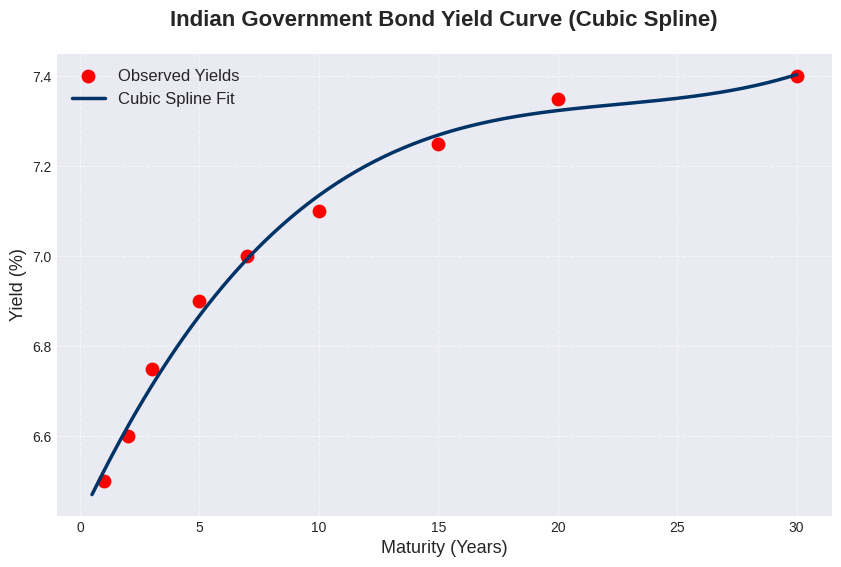

In [24]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Fit cubic spline with smoothing (s=0 -> exact interpolation)
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Generate smooth curve
tau_range = np.linspace(0.5, 30, 300)
spline_curve = spline(tau_range)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="red", s=80, label="Observed Yields")
plt.plot(tau_range, spline_curve, color="#003366", linewidth=2.5, label="Cubic Spline Fit")
plt.title("Indian Government Bond Yield Curve (Cubic Spline)", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


####Compare the models in terms of 1)Nelson-Siegel model fit & 2(Cubic-Spline model and interpretation

In-Sample Fit Comparison:
Nelson-Siegel RMSE: 0.01762
Cubic Spline RMSE:  0.02544


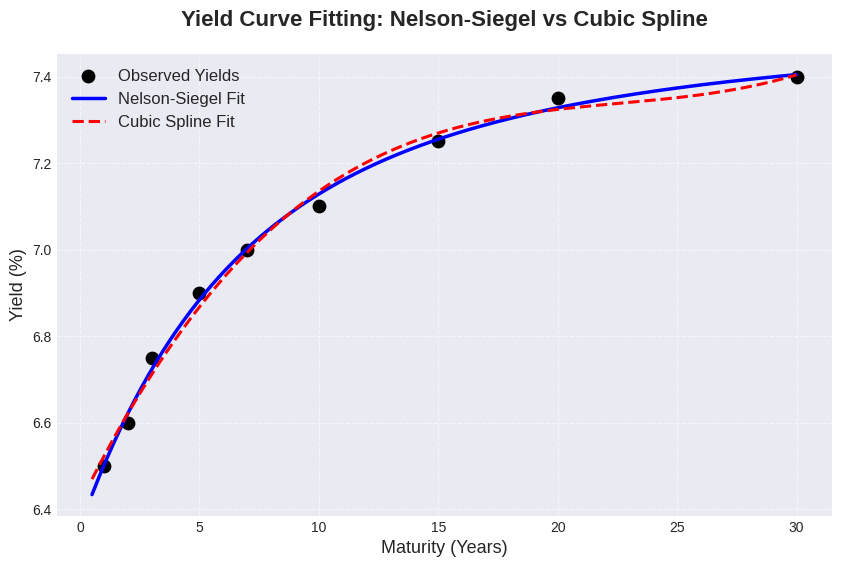

In [25]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit Nelson-Siegel
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)
beta0, beta1, beta2, lambd = popt

# Fit cubic spline
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Predictions at observed maturities
ns_pred = nelson_siegel(yield_curve["Years"], *popt)
spline_pred = spline(yield_curve["Years"])

# RMSE calculations
rmse_ns = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], ns_pred))
rmse_spline = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], spline_pred))

print("In-Sample Fit Comparison:")
print(f"Nelson-Siegel RMSE: {rmse_ns:.5f}")
print(f"Cubic Spline RMSE:  {rmse_spline:.5f}")

# Generate smooth curves for plotting
tau_range = np.linspace(0.5, 30, 300)
ns_curve = nelson_siegel(tau_range, *popt)
spline_curve = spline(tau_range)

# Plot comparison
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="black", s=80, label="Observed Yields")
plt.plot(tau_range, ns_curve, color="blue", linewidth=2.5, label="Nelson-Siegel Fit")
plt.plot(tau_range, spline_curve, color="red", linestyle="--", linewidth=2.2, label="Cubic Spline Fit")
plt.title("Yield Curve Fitting: Nelson-Siegel vs Cubic Spline", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


##Specify the levels of model parameters (ex. Alpha1).

In [26]:


# Example Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit NS
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)
beta0, beta1, beta2, lambd = popt

# Fit spline
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Predictions
ns_pred = nelson_siegel(yield_curve["Years"], *popt)
spline_pred = spline(yield_curve["Years"])

# RMSE
rmse_ns = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], ns_pred))
rmse_spline = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], spline_pred))

print("\n=== Parameter Estimates ===")
print("Nelson-Siegel Parameters:")
print(f"β0 (Level)   = {beta0:.5f}")
print(f"β1 (Slope)   = {beta1:.5f}")
print(f"β2 (Curvature) = {beta2:.5f}")
print(f"λ  (Decay)   = {lambd:.5f}")

print("\nCubic Spline Parameters (α_j):")
print(spline.get_coeffs())  # spline α_j coefficients

print("\n=== In-Sample Fit ===")
print(f"Nelson-Siegel RMSE: {rmse_ns:.5f}")
print(f"Cubic Spline RMSE:  {rmse_spline:.5f}")



=== Parameter Estimates ===
Nelson-Siegel Parameters:
β0 (Level)   = 7.56054
β1 (Slope)   = -1.20056
β2 (Curvature) = 0.00068
λ  (Decay)   = 0.25644

Cubic Spline Parameters (α_j):
[6.52238653 7.52219922 7.24327714 7.40415403]

=== In-Sample Fit ===
Nelson-Siegel RMSE: 0.01762
Cubic Spline RMSE:  0.02544
